In [1]:
%matplotlib inline
from astropy.io import fits as pf
import numpy as np
import matplotlib.pyplot as pl
from glob import glob

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.time import Time

from photutils import SkyCircularAperture
from photutils import CircularAnnulus, SkyCircularAnnulus
from photutils import aperture_photometry


pl.rcParams['figure.figsize'] = (20.0, 20.0)
pl.rcParams['font.size'] = 15
pl.rcParams['font.family'] = 'sans'
#pl.rcParams['font.family'] = 'CMU Sans Serif'
pl.rcParams['axes.linewidth'] = 2 #set the value globally
pl.rcParams['lines.linewidth'] = 2 #set the value globally

In [2]:
path = "/Users/jmsantander/nustar/txs/sk/"

def doPhotometry(hdu):
    
    wcs = WCS(hdu[0].header)
    expo = hdu[0].header['ONTIME']
    
    # circular aperture centered on object
    position = SkyCoord(ra=[hdu[0].header['RA_OBJ'] * u.deg], dec=[hdu[0].header['DEC_OBJ'] * u.deg], frame='fk5')
    aperture = SkyCircularAperture(position, r=75. * u.arcsec)
    pixap = aperture.to_pixel(wcs)
    pixpos = position.to_pixel(wcs)

    # annular aperture center on object
    annulus_aperture = SkyCircularAnnulus(position, r_in=105 * u.arcsec, r_out= 170 * u.arcsec)
    annap = annulus_aperture.to_pixel(wcs)

    apers = [pixap, annap]
    phot_table = aperture_photometry(hdu[0].data, apers)

    bkg_mean = phot_table['aperture_sum_1'] / annap.area
    bkg_sum = bkg_mean * pixap.area

    final_sum = phot_table['aperture_sum_0'] - bkg_sum
    
    # write to the table
    phot_table['residual_aperture_sum'] = final_sum
    phot_table['residual_aperture_sum'].info.format = '%.8g'  # for consistent table output
    
    phot_table['residual_count_rate'] = final_sum / expo
    phot_table['residual_count_rate'].info.format = '%.8g'  # for consistent table output
    
    phot_table['residual_count_rate_err'] = np.sqrt(final_sum) / expo
    phot_table['residual_count_rate'].info.format = '%.8g'  # for consistent table output
    
    return(hdu[0].data, phot_table, apers, expo)

def plotSkymaps(Aphot, Bphot):
    fig = pl.figure()
    
    ax1 = fig.add_subplot(121)
    ax1.set_title('A')
    ax1.imshow(Aphot[0], vmax=3, origin='lower')
    Aphot[2][0].plot(color='white', lw=2)
    Aphot[2][1].plot(color='yellow')
    
    ax2 = fig.add_subplot(122)
    ax2.set_title('B')
    ax2.imshow(Bphot[0], vmax=3, origin='lower')
    Bphot[2][0].plot(color='white', lw=2)
    Bphot[2][1].plot(color='yellow')
    
def getMeanMJD(Ahdu, Bhdu):
    mjdAstart = Time(Ahdu[0].header['DATE-OBS']).mjd
    mjdBstart = Time(Bhdu[0].header['DATE-OBS']).mjd
    
    mjdAend = Time(Ahdu[0].header['DATE-END']).mjd
    mjdBend = Time(Bhdu[0].header['DATE-END']).mjd

    return((mjdAstart + mjdAend)/2., (mjdBstart + mjdBend)/2.)
    
def processFiles(path):
    Afiles = np.sort(glob(path + "*A*gz"))
    Bfiles = np.sort(glob(path + "*B*gz"))
    
    mjd = []
    crate = []
    crate_err = []
    
    for (Af, Bf) in zip(Afiles,Bfiles):
        Ahdu = pf.open(Af)
        Bhdu = pf.open(Bf)
        Aphot = doPhotometry(Ahdu)
        Bphot = doPhotometry(Bhdu)
        
        plotSkymaps(Aphot, Bphot)
        
        totsum = Aphot[1]['residual_aperture_sum'][0] + Bphot[1]['residual_aperture_sum'][0]
        totsum_err = np.sqrt(totsum)
        
        cr = totsum / (Aphot[3] + Bphot[3])
        cr_err = totsum_err / (Aphot[3] + Bphot[3])
        meanMJD = getMeanMJD(Ahdu, Bhdu)
        
        mjd.append(meanMJD[0])
        crate.append(cr)
        crate_err.append(cr_err)
    
    return(mjd, crate, crate_err)

        


#apers = [pixap, annulus_aperture]
#phot_table = aperture_photometry(hdu[0], apers)
        
    
    

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Invalid parameter values: MJD-OBS and DATE-OBS are inconsistent.
Set MJD-END to 58695.441771 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Invalid parameter values: MJD-OBS and DATE-OBS are inconsistent.
Set MJD-END to 58695.441771 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Invalid parameter values: MJD-OBS and DATE-OBS are inconsistent.
Set MJD-END to 58756.556354 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Invalid parameter values: MJD-OBS and DATE-OBS are inconsistent.
Set MJD-END to 58756.556354 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Invalid parameter values: MJD-OBS and DATE-OBS are inconsistent.
Set MJD-END to 58816.573715 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is d

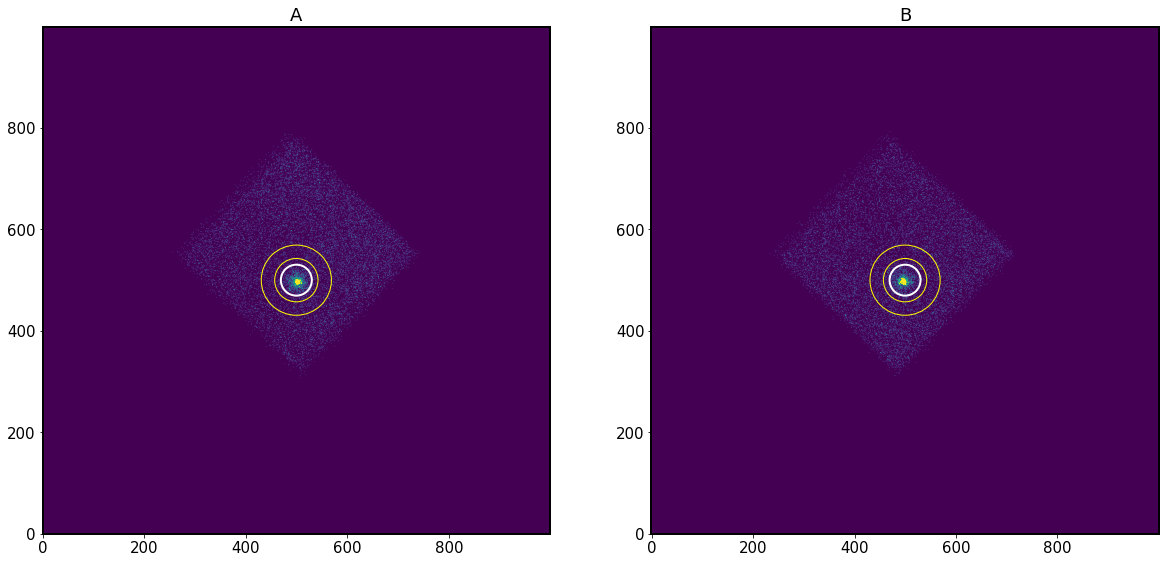

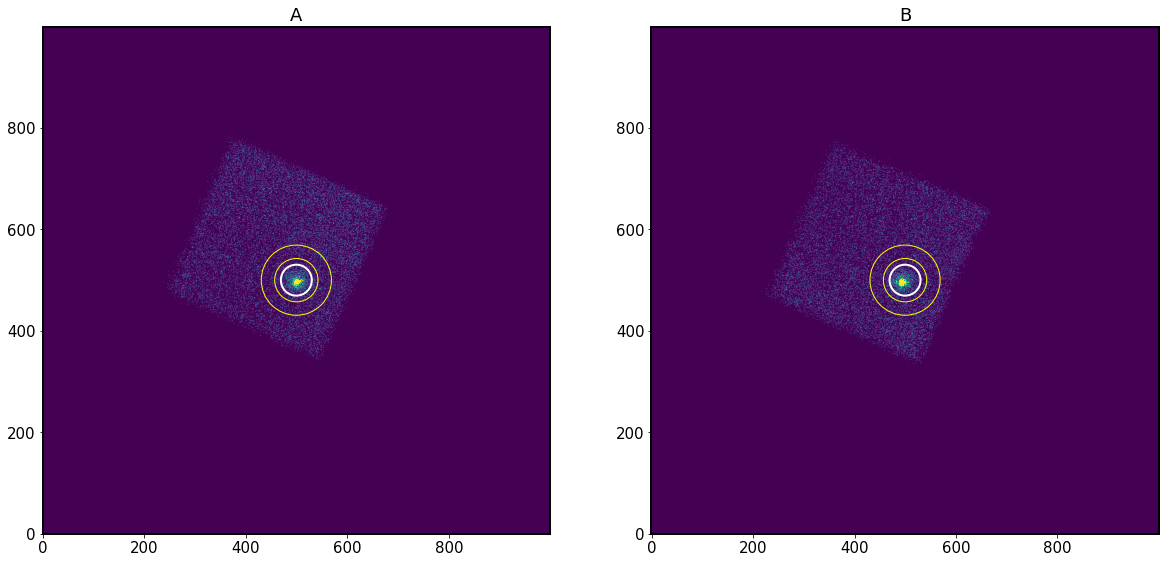

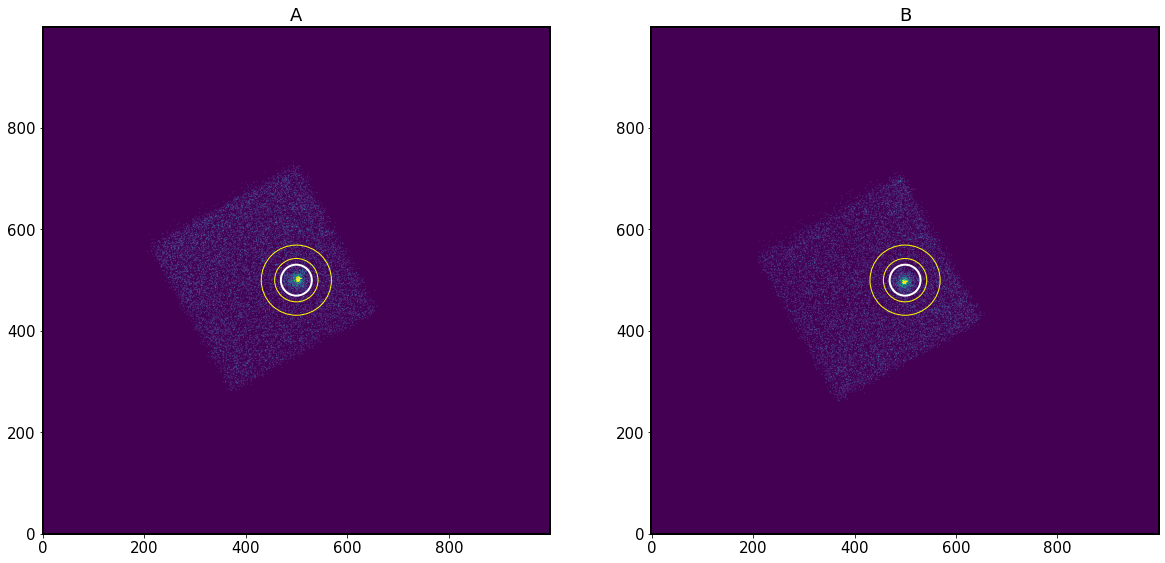

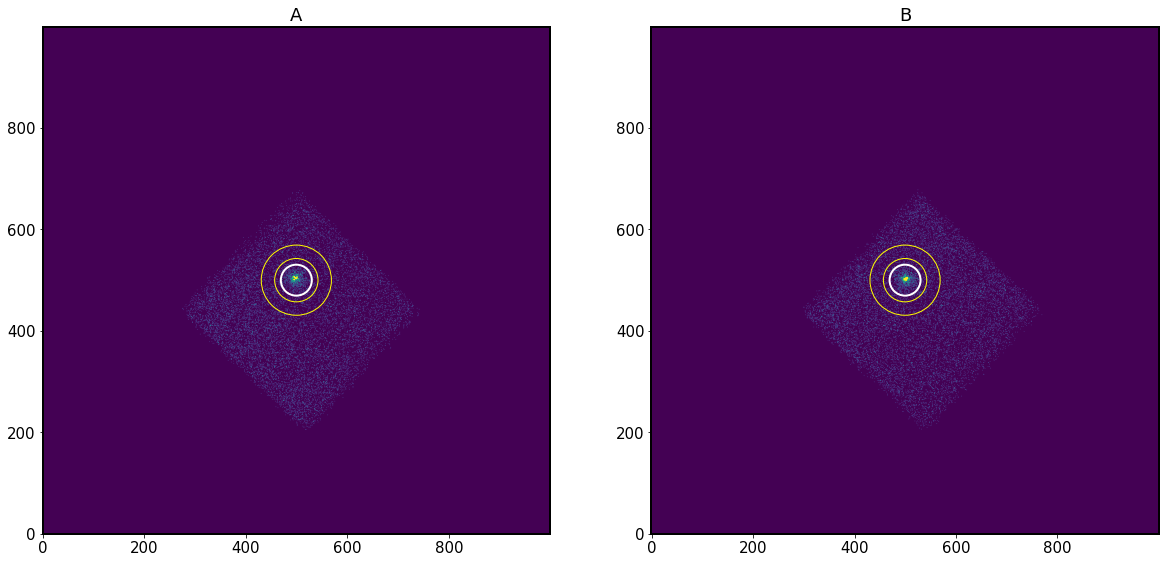

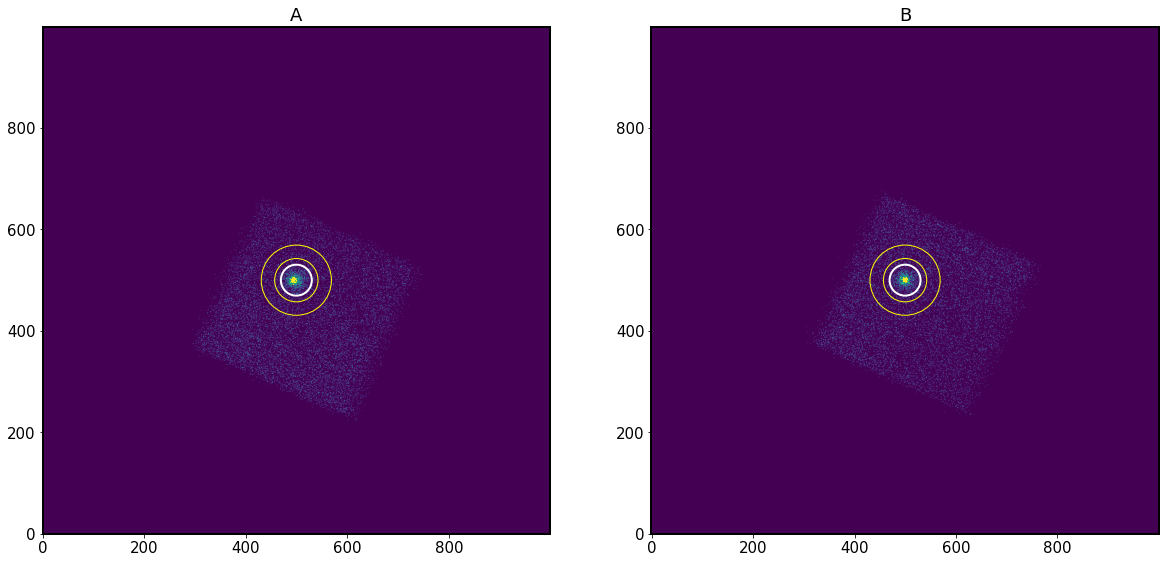

In [3]:
results = processFiles(path)

58695.16746527778 0.060541778862014575 0.0011219402347803931
58756.190034722225 0.05013790413916838 0.0008541709919452026
58816.330659722225 0.04805496839453433 0.00104587824962814
58875.068506944444 0.04199219502114194 0.0009947149481503623
58933.34107638889 0.058926037148993554 0.0011305492700157485


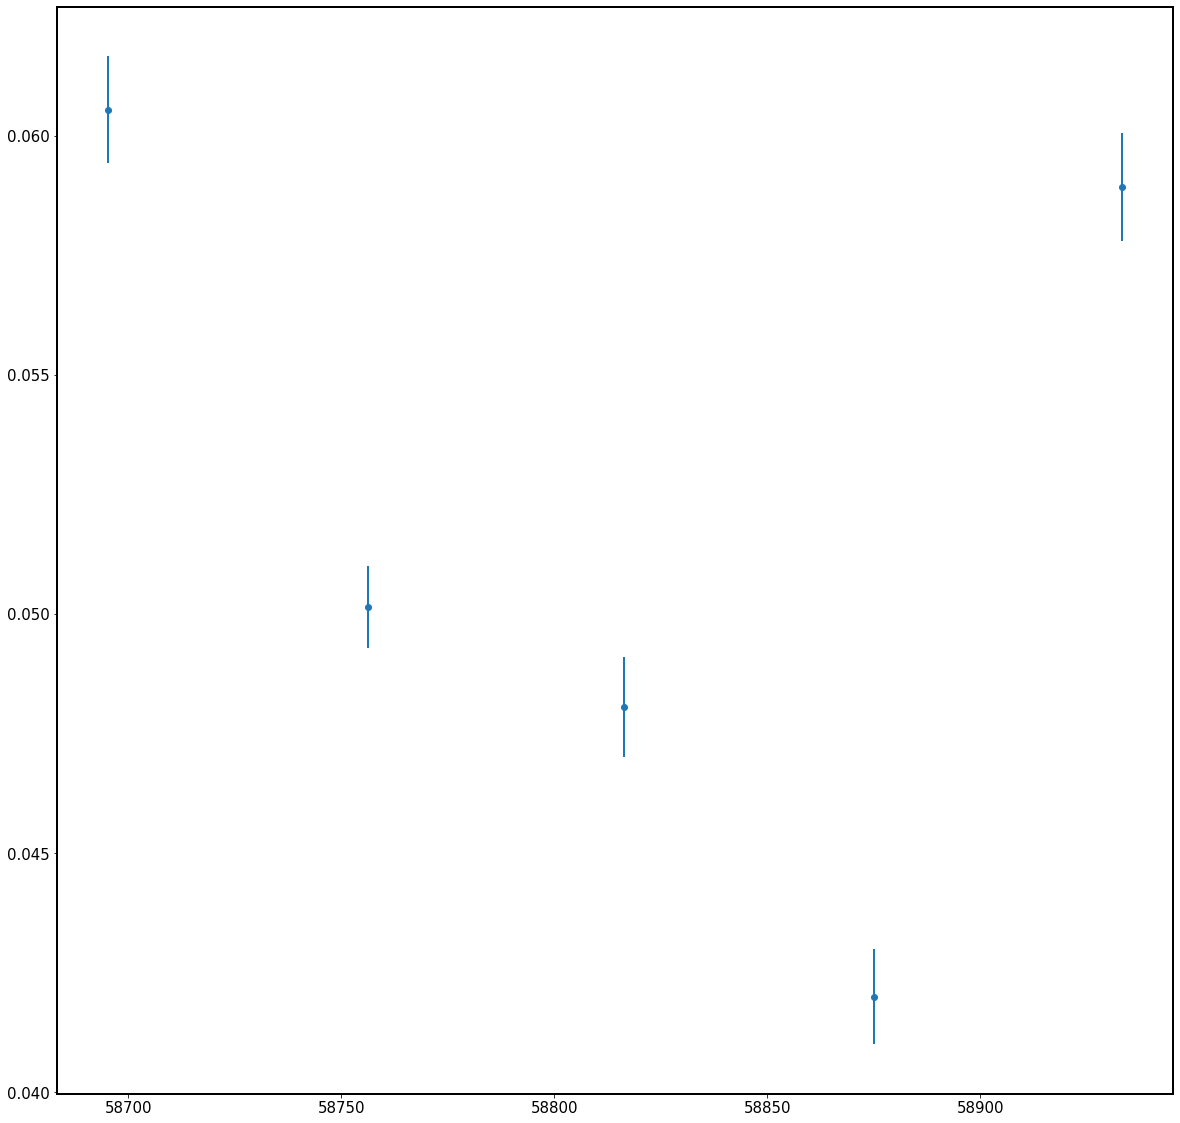

In [4]:
pl.errorbar(results[0], results[1], yerr=results[2],linestyle='',marker='o')

for (mjd, rate, rate_err) in zip(results[0], results[1], results[2]):
    print(mjd, rate, rate_err)

In [5]:
swift = np.genfromtxt(path + "curve_plain.dat", skip_header=12)

In [6]:
swiftt0 = Time("2009-02-20T09:14:57.487") 
swift_time = [t.mjd for t in swift[:,0] * u.second + swiftt0]

<ipython-input-13-27de621b799e>:5: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  vtstimes = np.genfromtxt(path + "vts_times.dat",dtype=None)


(58900.0, 58910.0)

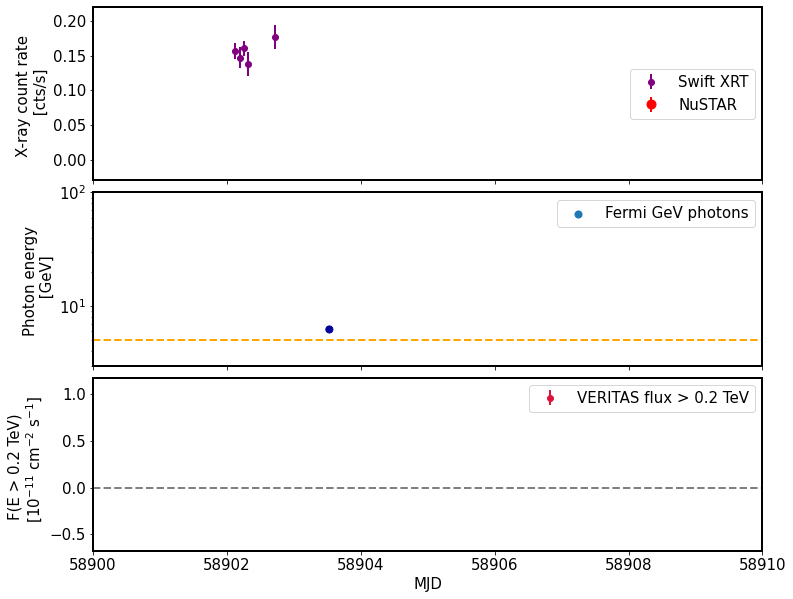

In [13]:
#fig = pl.figure(figsize=(12,7))

fig, (ax1, ax2, ax3) = pl.subplots(3, sharex=True, figsize=(12,10), gridspec_kw={'hspace': 0.07})

vtstimes = np.genfromtxt(path + "vts_times.dat",dtype=None)
vtsmjd = [t.mjd for t in Time(vtstimes)]

for v in vtsmjd:
    ax1.axvline(v,color='gray',alpha=0.2)
    
ax1.errorbar(swift_time, swift[:,3], yerr=(swift[:,5], -swift[:,4]),linestyle='',marker='o',label='Swift XRT', color='purple',alpha=1)
ax1.errorbar(results[0], results[1], yerr=results[2],linestyle='',marker='o',color='red',label='NuSTAR',markersize=9)

covid = Time("2020-03-18T00:00:00.00")

ax1.axvspan(covid.mjd, covid.mjd+100, alpha=0.1)

start = Time("2019-09-20T00:00:00.00")
ax1.axvspan(start.mjd-100, start.mjd, alpha=0.1)

ax1.set_xlim(58660, 59000)
ax1.set_ylim(-0.03,0.22)
ax1.set_ylabel('X-ray count rate \n [cts/s]')
ax1.legend()

RA0 = 77.35818295462
Dec0 = 5.69313769680311


#for fermifile in glob(path + "/fermi/*PH*fits"):
for fermifile in glob(path + "/fermi/txs*fits"):

    hdufermi = pf.open(fermifile)
    fermidata = hdufermi[1].data
    r = np.sqrt((fermidata['RA'] - RA0)**2 +  (fermidata['DEC'] - Dec0)**2)
    rcut = r < 0.6
    ax2.scatter(51910 + fermidata[rcut]['TIME']/(24*3600) , fermidata[rcut]['ENERGY']/1e3, c=fermidata[rcut]['ENERGY']/1e3,cmap=pl.get_cmap('jet'), s=50, label='Fermi GeV photons')

ax2.set_yscale('log')
ax2.set_ylim(3,100)
ax2.axhline(5,linestyle='--', color='orange')
ax2.set_ylabel('Photon energy \n [GeV]')
ax2.legend()


ax3.set_xlabel('MJD')

vts = np.genfromtxt("/Users/jmsantander/nustar/txs/RGB_J0509p056.result.flux.txt", skip_header=1)

ax3.errorbar(vts[:,0], vts[:,1]*1e11, yerr=vts[:,2]*1e11,linestyle='',marker='o',label='VERITAS flux > 0.2 TeV', color='crimson',alpha=1)
ax3.set_ylabel('F(E > 0.2 TeV) \n  [$10^{-11}$ cm$^{-2}$ s$^{-1}$]')
ax3.legend()
ax3.axhline(0, linestyle='--', color='gray')


pl.savefig("/Users/jmsantander/nustar/txs/lc.pdf")
pl.xlim(58900,58910)


In [9]:
swift_time

[54882.46017827546,
 55037.34972521991,
 55037.41346175926,
 55037.46588087963,
 55037.532186655095,
 55037.61154351852,
 55037.67564940972,
 55538.38841273148,
 55663.38599636574,
 55771.0222830787,
 55771.351598217596,
 58019.007404108794,
 58019.09174667824,
 58019.151398344904,
 58019.220510555555,
 58019.332213229165,
 58019.620294594904,
 58019.73723653935,
 58019.86368318287,
 58023.79896667824,
 58023.86233564815,
 58023.916667094905,
 58026.195005775466,
 58026.26184829861,
 58028.64218043981,
 58029.57469729167,
 58029.77557244213,
 58030.699880231485,
 58030.71044796296,
 58030.77056077546,
 58031.70079267361,
 58031.75905260417,
 58031.89448001157,
 58032.558397106484,
 58033.02301168982,
 58033.23431950231,
 58034.42337400463,
 58034.47974980324,
 58040.94536946759,
 58042.60342881944,
 58042.79195196759,
 58042.86829427083,
 58042.93561888889,
 58044.064233599536,
 58044.130927858794,
 58044.19687341435,
 58046.58052234953,
 58047.779659513886,
 58047.84357719908,
 58050.

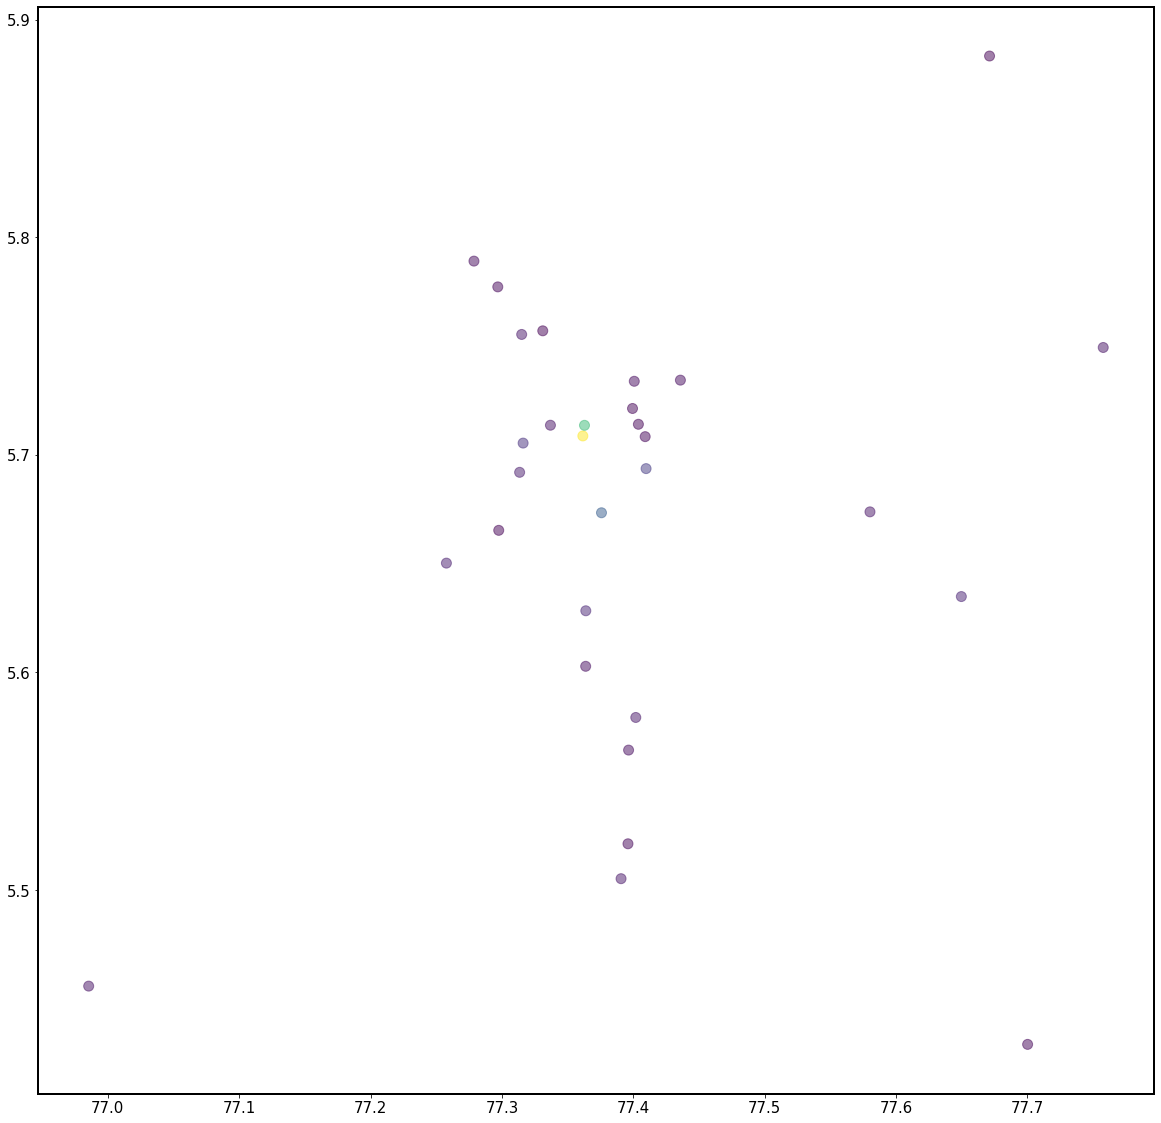

In [8]:
for fermifile in glob(path + "/fermi/txs*fits"):

    hdufermi = pf.open(fermifile)
    fermidata = hdufermi[1].data
    r = np.sqrt((fermidata['RA'] - RA0)**2 +  (fermidata['DEC'] - Dec0)**2)
    rcut = r < 0.5
    pl.scatter(fermidata[rcut]['RA'], fermidata[rcut]['DEC'], c=fermidata[rcut]['ENERGY']/1e3,cmap=pl.get_cmap('viridis'), alpha=0.5,s=100)


In [43]:
expo

24046.87502777576